In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from datetime import datetime 
import cv2
from PIL import Image
from keras import backend, optimizers

2023-03-07 17:51:14.004002: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-07 17:51:14.201996: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-03-07 17:51:14.877664: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cm/shared/apps/cudnn-8.4/8.4/lib64:/cm/local/apps/cuda/libs/current/lib64:/cm/shared/apps/cuda11.2/toolkit/11.2.0/targets/x86_64-linux/lib:/cm/local/apps/gcc/7.2.0/lib:/cm/local/apps/gcc/7.2.0/lib64:/hom

In [8]:
image_directory = 'imgs/Resized_Skin_Lesion_Dataset/Train_images/Trainx/'
mask_directory = 'imgs/Resized_Skin_Lesion_Dataset/Train_masks/Trainy/'

In [9]:
SIZE = 256
image_dataset = []  #Many ways to handle data, you can use pandas. Here, we are using a list format.  
mask_dataset = []  #Place holders to define add labels. We will add 0 to all parasitized images and 1 to uninfected.

images = os.listdir(image_directory)
for i, image_name in enumerate(images):    #Remember enumerate method adds a counter and returns the enumerate object
    if (image_name.split('.')[1] == 'bmp'):
        #print(image_directory+image_name)
        image = cv2.imread(image_directory+image_name, 1)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB )
        image = Image.fromarray(image)
        image = image.resize((SIZE, SIZE))
        image_dataset.append(np.array(image))

In [10]:
masks = os.listdir(mask_directory)
for i, image_name in enumerate(masks):
    if (image_name.split('.')[1] == 'bmp'):
        image = cv2.imread(mask_directory+image_name, 0)
        image = Image.fromarray(image)
        image = image.resize((SIZE, SIZE))
        mask_dataset.append(np.array(image))

In [11]:
#Normalize images
image_dataset = np.array(image_dataset)/255.
#D not normalize masks, just rescale to 0 to 1.
mask_dataset = np.expand_dims((np.array(mask_dataset)),3) /255.

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset, test_size = 0.10, random_state = 0)

In [13]:
X_train.shape

(180, 256, 256, 3)

In [14]:
y_train.shape

(180, 256, 256, 1)

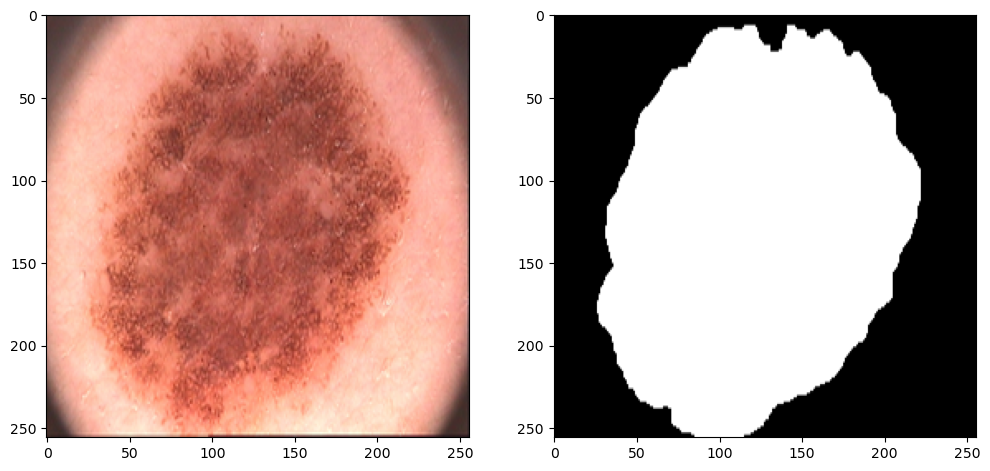

In [15]:
import random
import numpy as np
image_number = random.randint(0, len(X_train))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(X_train[image_number], (256, 256, 3)))
plt.subplot(122)
plt.imshow(np.reshape(y_train[image_number], (256, 256)), cmap='gray')
plt.show()

In [16]:
IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]
num_labels = 1  #Binary
input_shape = (IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS)
batch_size = 8

#FOCAL LOSS AND DICE METRIC
#Focal loss helps focus more on tough to segment classes.
from focal_loss import BinaryFocalLoss

In [17]:
import tensorflow as tf
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras import backend as K

In [18]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2.0 * intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1.0)


def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)


def jacard_coef_loss(y_true, y_pred):
    return -jacard_coef(y_true, y_pred)


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [19]:
def repeat_elem(tensor, rep):
    # lambda function to repeat Repeats the elements of a tensor along an axis
    #by a factor of rep.
    # If tensor has shape (None, 256,256,3), lambda will return a tensor of shape 
    #(None, 256,256,6), if specified axis=3 and rep=2.

     return layers.Lambda(lambda x, repnum: K.repeat_elements(x, repnum, axis=3),
                          arguments={'repnum': rep})(tensor)


def res_conv_block(x, filter_size, size, dropout, batch_norm=False):
    '''
    Residual convolutional layer.
    Two variants....
    Either put activation function before the addition with shortcut
    or after the addition (which would be as proposed in the original resNet).
    
    1. conv - BN - Activation - conv - BN - Activation 
                                          - shortcut  - BN - shortcut+BN
                                          
    2. conv - BN - Activation - conv - BN   
                                     - shortcut  - BN - shortcut+BN - Activation                                     
    
    Check fig 4 in https://arxiv.org/ftp/arxiv/papers/1802/1802.06955.pdf
    '''

    conv = layers.Conv2D(size, (filter_size, filter_size), padding='same')(x)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation('relu')(conv)
    
    conv = layers.Conv2D(size, (filter_size, filter_size), padding='same')(conv)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    #conv = layers.Activation('relu')(conv)    #Activation before addition with shortcut
    if dropout > 0:
        conv = layers.Dropout(dropout)(conv)

    shortcut = layers.Conv2D(size, kernel_size=(1, 1), padding='same')(x)
    if batch_norm is True:
        shortcut = layers.BatchNormalization(axis=3)(shortcut)

    res_path = layers.add([shortcut, conv])
    res_path = layers.Activation('relu')(res_path)    #Activation after addition with shortcut (Original residual block)
    return res_path

def gating_signal(input, out_size, batch_norm=False):
    """
    resize the down layer feature map into the same dimension as the up layer feature map
    using 1x1 conv
    :return: the gating feature map with the same dimension of the up layer feature map
    """
    x = layers.Conv2D(out_size, (1, 1), padding='same')(input)
    if batch_norm:
        x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    return x

def attention_block(x, gating, inter_shape):
    shape_x = K.int_shape(x)
    shape_g = K.int_shape(gating)

# Getting the x signal to the same shape as the gating signal
    theta_x = layers.Conv2D(inter_shape, (2, 2), strides=(2, 2), padding='same')(x)  # 16
    shape_theta_x = K.int_shape(theta_x)

# Getting the gating signal to the same number of filters as the inter_shape
    phi_g = layers.Conv2D(inter_shape, (1, 1), padding='same')(gating)
    upsample_g = layers.Conv2DTranspose(inter_shape, (3, 3),
                                 strides=(shape_theta_x[1] // shape_g[1], shape_theta_x[2] // shape_g[2]),
                                 padding='same')(phi_g)  # 16

    concat_xg = layers.add([upsample_g, theta_x])
    act_xg = layers.Activation('relu')(concat_xg)
    psi = layers.Conv2D(1, (1, 1), padding='same')(act_xg)
    sigmoid_xg = layers.Activation('sigmoid')(psi)
    shape_sigmoid = K.int_shape(sigmoid_xg)
    upsample_psi = layers.UpSampling2D(size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(sigmoid_xg)  # 32

    upsample_psi = repeat_elem(upsample_psi, shape_x[3])

    y = layers.multiply([upsample_psi, x])

    result = layers.Conv2D(shape_x[3], (1, 1), padding='same')(y)
    result_bn = layers.BatchNormalization()(result)
    return result_bn

In [20]:
def Attention_ResUNet(input_shape, NUM_CLASSES=1, dropout_rate=0.0, batch_norm=True):
    '''
    Rsidual UNet, with attention 
    
    '''
    # network structure
    FILTER_NUM = 64 # number of basic filters for the first layer
    FILTER_SIZE = 3 # size of the convolutional filter
    UP_SAMP_SIZE = 2 # size of upsampling filters
    # input data
    # dimension of the image depth
    inputs = layers.Input(input_shape, dtype=tf.float32)
    axis = 3

    # Downsampling layers
    # DownRes 1, double residual convolution + pooling
    conv_128 = res_conv_block(inputs, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)
    pool_64 = layers.MaxPooling2D(pool_size=(2,2))(conv_128)
    # DownRes 2
    conv_64 = res_conv_block(pool_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    pool_32 = layers.MaxPooling2D(pool_size=(2,2))(conv_64)
    # DownRes 3
    conv_32 = res_conv_block(pool_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    pool_16 = layers.MaxPooling2D(pool_size=(2,2))(conv_32)
    # DownRes 4
    conv_16 = res_conv_block(pool_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    pool_8 = layers.MaxPooling2D(pool_size=(2,2))(conv_16)
    # DownRes 5, convolution only
    conv_8 = res_conv_block(pool_8, FILTER_SIZE, 16*FILTER_NUM, dropout_rate, batch_norm)

    # Upsampling layers
    # UpRes 6, attention gated concatenation + upsampling + double residual convolution
    gating_16 = gating_signal(conv_8, 8*FILTER_NUM, batch_norm)
    att_16 = attention_block(conv_16, gating_16, 8*FILTER_NUM)
    up_16 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(conv_8)
    up_16 = layers.concatenate([up_16, att_16], axis=axis)
    up_conv_16 = res_conv_block(up_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 7
    gating_32 = gating_signal(up_conv_16, 4*FILTER_NUM, batch_norm)
    att_32 = attention_block(conv_32, gating_32, 4*FILTER_NUM)
    up_32 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_16)
    up_32 = layers.concatenate([up_32, att_32], axis=axis)
    up_conv_32 = res_conv_block(up_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 8
    gating_64 = gating_signal(up_conv_32, 2*FILTER_NUM, batch_norm)
    att_64 = attention_block(conv_64, gating_64, 2*FILTER_NUM)
    up_64 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_32)
    up_64 = layers.concatenate([up_64, att_64], axis=axis)
    up_conv_64 = res_conv_block(up_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 9
    gating_128 = gating_signal(up_conv_64, FILTER_NUM, batch_norm)
    att_128 = attention_block(conv_128, gating_128, FILTER_NUM)
    up_128 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_64)
    up_128 = layers.concatenate([up_128, att_128], axis=axis)
    up_conv_128 = res_conv_block(up_128, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)

    # 1*1 convolutional layers
    
    conv_final = layers.Conv2D(NUM_CLASSES, kernel_size=(1,1))(up_conv_128)
    conv_final = layers.BatchNormalization(axis=axis)(conv_final)
    conv_final = layers.Activation('sigmoid')(conv_final)  #Change to softmax for multichannel

    # Model integration
    model = models.Model(inputs, conv_final, name="AttentionResUNet")
    return model

In [21]:
att_res_unet_model = Attention_ResUNet(input_shape)

att_res_unet_model.compile(optimizer=Adam(lr = 1e-2), loss=BinaryFocalLoss(gamma=2), 
              metrics=['accuracy', jacard_coef])


# att_res_unet_model.compile(optimizer=Adam(lr = 1e-3), loss='binary_crossentropy', 
#               metrics=['accuracy', jacard_coef])

print(att_res_unet_model.summary())


start3 = datetime.now() 
att_res_unet_history = att_res_unet_model.fit(X_train, y_train, 
                    verbose=1,
                    batch_size = batch_size,
                    validation_data=(X_test, y_test ), 
                    shuffle=False,
                    epochs=150)
stop3 = datetime.now()

#Execution time of the model 
execution_time_AttResUnet = stop3-start3
print("Attention ResUnet execution time is: ", execution_time_AttResUnet)

att_res_unet_model.save('skin_AttResUnet_50epochs_B_focal.hdf5')


2023-03-07 17:52:12.655612: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-07 17:52:13.325333: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14625 MB memory:  -> device: 0, name: Tesla V100-PCIE-16GB, pci bus id: 0000:3b:00.0, compute capability: 7.0


Model: "AttentionResUNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                  

                                                                  'batch_normalization_7[0][0]']  
                                                                                                  
 activation_5 (Activation)      (None, 64, 64, 256)  0           ['add_2[0][0]']                  
                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, 32, 32, 256)  0          ['activation_5[0][0]']           
                                                                                                  
 conv2d_9 (Conv2D)              (None, 32, 32, 512)  1180160     ['max_pooling2d_2[0][0]']        
                                                                                                  
 batch_normalization_9 (BatchNo  (None, 32, 32, 512)  2048       ['conv2d_9[0][0]']               
 rmalization)                                                                                     
          

                                                                                                  
 multiply (Multiply)            (None, 32, 32, 512)  0           ['lambda[0][0]',                 
                                                                  'activation_7[0][0]']           
                                                                                                  
 conv2d_19 (Conv2D)             (None, 32, 32, 512)  262656      ['multiply[0][0]']               
                                                                                                  
 up_sampling2d_1 (UpSampling2D)  (None, 32, 32, 1024  0          ['activation_9[0][0]']           
                                )                                                                 
                                                                                                  
 batch_normalization_16 (BatchN  (None, 32, 32, 512)  2048       ['conv2d_19[0][0]']              
 ormalizat

                                                                                                  
 conv2d_30 (Conv2D)             (None, 64, 64, 256)  196864      ['concatenate_1[0][0]']          
                                                                                                  
 conv2d_29 (Conv2D)             (None, 64, 64, 256)  590080      ['activation_18[0][0]']          
                                                                                                  
 batch_normalization_24 (BatchN  (None, 64, 64, 256)  1024       ['conv2d_30[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_23 (BatchN  (None, 64, 64, 256)  1024       ['conv2d_29[0][0]']              
 ormalization)                                                                                    
          

 activation_24 (Activation)     (None, 128, 128, 12  0           ['add_10[0][0]']                 
                                8)                                                                
                                                                                                  
 conv2d_39 (Conv2D)             (None, 128, 128, 64  8256        ['activation_24[0][0]']          
                                )                                                                 
                                                                                                  
 batch_normalization_30 (BatchN  (None, 128, 128, 64  256        ['conv2d_39[0][0]']              
 ormalization)                  )                                                                 
                                                                                                  
 activation_25 (Activation)     (None, 128, 128, 64  0           ['batch_normalization_30[0][0]'] 
          

 activation_30 (Activation)     (None, 256, 256, 1)  0           ['batch_normalization_35[0][0]'] 
                                                                                                  
Total params: 39,090,377
Trainable params: 39,068,871
Non-trainable params: 21,506
__________________________________________________________________________________________________


/home/ok_sikha/anaconda3/envs/tf_gpu_segnet/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


None
Epoch 1/150


2023-03-07 17:52:22.233318: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


23/23 [==============================] - 24s 484ms/step - loss: 0.1212 - accuracy: 0.8147 - jacard_coef: 0.3542 - val_loss: 4.1803 - val_accuracy: 0.7406 - val_jacard_coef: 1.3103e-05
Epoch 2/150
23/23 [==============================] - 6s 269ms/step - loss: 0.0807 - accuracy: 0.8753 - jacard_coef: 0.3865 - val_loss: 4.1803 - val_accuracy: 0.7406 - val_jacard_coef: 1.3103e-05
Epoch 3/150
23/23 [==============================] - 6s 264ms/step - loss: 0.0710 - accuracy: 0.8909 - jacard_coef: 0.4039 - val_loss: 1.5899 - val_accuracy: 0.7458 - val_jacard_coef: 0.0680
Epoch 4/150
23/23 [==============================] - 6s 266ms/step - loss: 0.0677 - accuracy: 0.8961 - jacard_coef: 0.4152 - val_loss: 1.2298 - val_accuracy: 0.2444 - val_jacard_coef: 0.1959
Epoch 5/150
23/23 [==============================] - 6s 267ms/step - loss: 0.0649 - accuracy: 0.9032 - jacard_coef: 0.4237 - val_loss: 1.9036 - val_accuracy: 0.2630 - val_jacard_coef: 0.2399
Epoch 6/150
23/23 [=============================

Epoch 44/150
23/23 [==============================] - 6s 265ms/step - loss: 0.0226 - accuracy: 0.9627 - jacard_coef: 0.6436 - val_loss: 0.1306 - val_accuracy: 0.8201 - val_jacard_coef: 0.4489
Epoch 45/150
23/23 [==============================] - 6s 266ms/step - loss: 0.0209 - accuracy: 0.9666 - jacard_coef: 0.6501 - val_loss: 0.1043 - val_accuracy: 0.8834 - val_jacard_coef: 0.4649
Epoch 46/150
23/23 [==============================] - 6s 266ms/step - loss: 0.0215 - accuracy: 0.9648 - jacard_coef: 0.6500 - val_loss: 0.0523 - val_accuracy: 0.9373 - val_jacard_coef: 0.5206
Epoch 47/150
23/23 [==============================] - 6s 264ms/step - loss: 0.0210 - accuracy: 0.9647 - jacard_coef: 0.6560 - val_loss: 0.0525 - val_accuracy: 0.9379 - val_jacard_coef: 0.5003
Epoch 48/150
23/23 [==============================] - 6s 266ms/step - loss: 0.0183 - accuracy: 0.9701 - jacard_coef: 0.6626 - val_loss: 0.0616 - val_accuracy: 0.9360 - val_jacard_coef: 0.5203
Epoch 49/150
23/23 [====================

Epoch 87/150
23/23 [==============================] - 6s 265ms/step - loss: 0.0099 - accuracy: 0.9818 - jacard_coef: 0.7571 - val_loss: 0.0897 - val_accuracy: 0.9243 - val_jacard_coef: 0.6075
Epoch 88/150
23/23 [==============================] - 6s 263ms/step - loss: 0.0095 - accuracy: 0.9827 - jacard_coef: 0.7608 - val_loss: 0.0811 - val_accuracy: 0.9311 - val_jacard_coef: 0.6092
Epoch 89/150
23/23 [==============================] - 6s 264ms/step - loss: 0.0096 - accuracy: 0.9823 - jacard_coef: 0.7639 - val_loss: 0.0745 - val_accuracy: 0.9391 - val_jacard_coef: 0.5990
Epoch 90/150
23/23 [==============================] - 6s 264ms/step - loss: 0.0102 - accuracy: 0.9815 - jacard_coef: 0.7594 - val_loss: 0.0789 - val_accuracy: 0.9324 - val_jacard_coef: 0.5997
Epoch 91/150
23/23 [==============================] - 6s 264ms/step - loss: 0.0114 - accuracy: 0.9799 - jacard_coef: 0.7553 - val_loss: 0.0777 - val_accuracy: 0.9329 - val_jacard_coef: 0.6327
Epoch 92/150
23/23 [====================

23/23 [==============================] - 6s 263ms/step - loss: 0.0108 - accuracy: 0.9808 - jacard_coef: 0.7800 - val_loss: 0.1181 - val_accuracy: 0.9268 - val_jacard_coef: 0.6461
Epoch 130/150
23/23 [==============================] - 6s 263ms/step - loss: 0.0116 - accuracy: 0.9798 - jacard_coef: 0.7695 - val_loss: 0.0834 - val_accuracy: 0.9371 - val_jacard_coef: 0.6608
Epoch 131/150
23/23 [==============================] - 6s 265ms/step - loss: 0.0110 - accuracy: 0.9807 - jacard_coef: 0.7673 - val_loss: 0.1066 - val_accuracy: 0.9194 - val_jacard_coef: 0.6537
Epoch 132/150
23/23 [==============================] - 6s 264ms/step - loss: 0.0117 - accuracy: 0.9802 - jacard_coef: 0.7681 - val_loss: 0.0939 - val_accuracy: 0.9324 - val_jacard_coef: 0.7018
Epoch 133/150
23/23 [==============================] - 6s 264ms/step - loss: 0.0093 - accuracy: 0.9827 - jacard_coef: 0.7717 - val_loss: 0.1145 - val_accuracy: 0.9241 - val_jacard_coef: 0.6567
Epoch 134/150
23/23 [============================

In [22]:
import pandas as pd    
att_res_unet_history_df = pd.DataFrame(att_res_unet_history.history) 

with open('custom_code_att_res_unet_history_df.csv', mode='w') as f:
    att_res_unet_history_df.to_csv(f) 

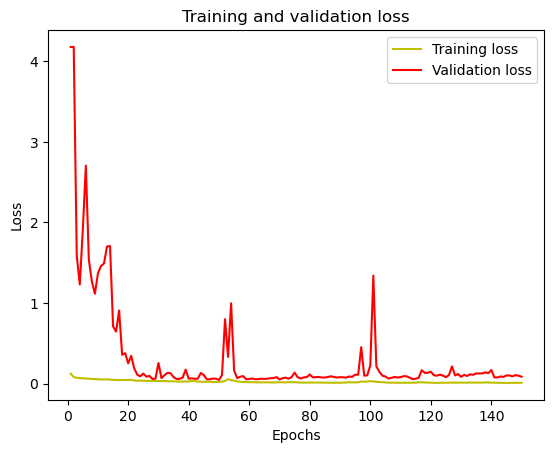

In [23]:
history = att_res_unet_history

#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

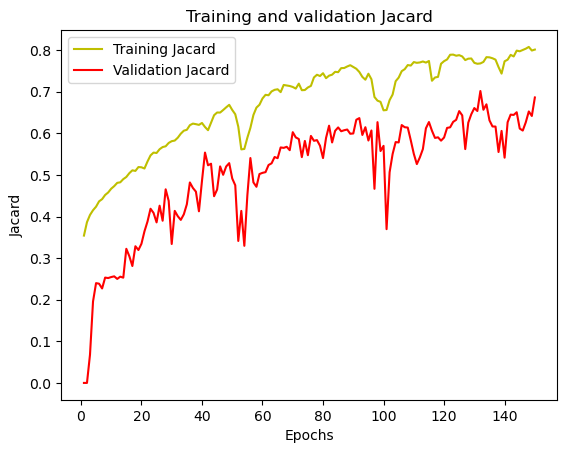

In [24]:
acc = history.history['jacard_coef']
#acc = history.history['accuracy']
val_acc = history.history['val_jacard_coef']
#val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training Jacard')
plt.plot(epochs, val_acc, 'r', label='Validation Jacard')
plt.title('Training and validation Jacard')
plt.xlabel('Epochs')
plt.ylabel('Jacard')
plt.legend()
plt.show()

In [25]:
model = att_res_unet_model
model_path = "skin_AttResUnet_50epochs_B_focal.hdf5"
model = tf.keras.models.load_model(model_path, compile=False)

1/1 [==============================] - 2s 2s/step


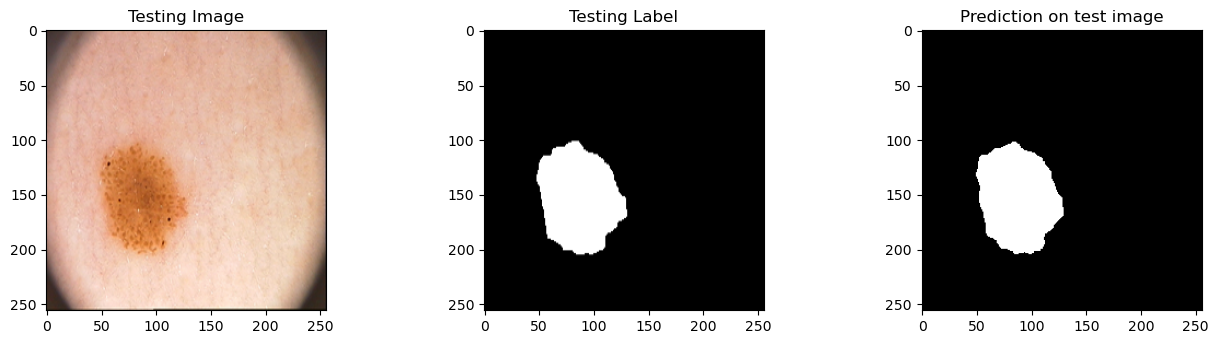

In [26]:
import random
test_img_number = random.randint(0, X_test.shape[0]-1)
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]

test_img_input=np.expand_dims(test_img, 0)
prediction = (model.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img, cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')

plt.show()

In [27]:
from tensorflow.keras.metrics import MeanIoU
n_classes = 2
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(ground_truth[:,:,0], prediction)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.97712815


In [29]:
import pandas as pd

IoU_values = []
for img in range(0, X_test.shape[0]):
    temp_img = X_test[img]
    ground_truth=y_test[img]
    temp_img_input=np.expand_dims(temp_img, 0)
    prediction = (model.predict(temp_img_input)[0,:,:,0] > 0.5).astype(np.uint8)
    
    IoU = MeanIoU(num_classes=n_classes)
    IoU.update_state(ground_truth[:,:,0], prediction)
    IoU = IoU.result().numpy()
    IoU_values.append(IoU)

    print(IoU)
    


df = pd.DataFrame(IoU_values, columns=["IoU"])
df = df[df.IoU != 1.0]    
mean_IoU = df.mean().values
print("Mean IoU is: ", mean_IoU)  

1/1 [==============================] - 0s 84ms/step
0.84919274
1/1 [==============================] - 0s 79ms/step
0.9430684
1/1 [==============================] - 0s 88ms/step
0.9519496
1/1 [==============================] - 0s 127ms/step
0.5120618
1/1 [==============================] - 0s 67ms/step
0.89878607
1/1 [==============================] - 0s 145ms/step
0.8031287
1/1 [==============================] - 0s 96ms/step
0.91078234
1/1 [==============================] - 0s 134ms/step
0.49575895
1/1 [==============================] - 0s 86ms/step
0.9408597
1/1 [==============================] - 0s 61ms/step
0.95739806
1/1 [==============================] - 0s 88ms/step
0.95057935
1/1 [==============================] - 0s 103ms/step
0.9167057
1/1 [==============================] - 0s 122ms/step
0.8982712
1/1 [==============================] - 0s 110ms/step
0.94884944
1/1 [==============================] - 0s 102ms/step
0.8944236
1/1 [==============================] - 0s 119ms/step
0.8